Synthesize complete items together with control variables for the norming experiment.

In [1]:
from collections import defaultdict
import re

from cedict_utils.cedict import CedictParser
import pandas as pd
import torch
import transformers
from tqdm.auto import tqdm

In [2]:
tqdm.pandas()

In [3]:
hanzi_model_ref = "bert-base-chinese"
"""Huggingface masked language model for Chinese hanzi"""

hanzi_causal_model_ref = "ckiplab/gpt2-base-chinese"
"""Huggingface causal language model for Chinese hanzi"""

'Huggingface causal language model for Chinese hanzi'

## Load and preprocess data

### Materials

In [4]:
item_df = pd.read_csv("intermediates/AISHELL/item_df.csv")
item_df["tok1_hanzi"] = item_df.apply(lambda row: row.hanzi.split(" ")[row.start_token_idx], axis=1)
item_df["tok1_alternate"] = item_df.tok1.transform(lambda tok1: tok1[:-1] + ("2" if tok1[-1] == "6" else "3"))
item_df.head(2)

,case,Unnamed: 1,file,hanzi,pinyin,pinyin_underlying,tok1,tok2,start_token_idx,end_token_idx,start_time,end_time,preceding_syllable_forms_word,slice_start,slice_end,slice_file,tok1_hanzi,tok1_alternate
0,2,0,SSB00090085,文 明 帝 国 有 什 么,wen2 ming2 di4 guo2 you3 shen2 me5,wen2 ming2 di4 guo2 you3 shen2 me5,guo2,you3,3,5,0.93,1.21,True,0,2210,intermediates/AISHELL/render/SSB00090085_guoyo...,国,guo3
1,2,1,SSB00330050,国 有 独 资 类 医 院 有 什 么,guo2 you3 du2 zi1 lei4 yi1 yuan4 you3 shen2 me5,guo2 you3 du2 zi1 lei4 yi1 yuan4 you3 shen2 me5,guo2,you3,0,2,0.26,0.86,False,0,1859,intermediates/AISHELL/render/SSB00330050_guoyo...,国,guo3


### Chinese dictionary (CEDICT)

In [5]:
parser = CedictParser()
parser.read_file("cedict_ts.u8")
entries = parser.parse()

cedict = defaultdict(set)
for entry in entries:
    cedict[entry.simplified].add(entry.pinyin.lower().replace("u:", "v"))

### Huggingface models

In [6]:
hanzi_model = transformers.BertLMHeadModel.from_pretrained(hanzi_model_ref, is_decoder=True)
hanzi_tokenizer = transformers.AutoTokenizer.from_pretrained(hanzi_model_ref)

In [7]:
hanzi_causal_model = transformers.AutoModelForCausalLM.from_pretrained(hanzi_causal_model_ref)
hanzi_causal_tokenizer = transformers.AutoTokenizer.from_pretrained(hanzi_causal_model_ref)

## Generate alternate `tok1` characters

In [8]:
def sample_alternate(hanzi_toks: list[str], replace_idx, target_reading):
    """
    Sample an alternate hanzi character at `replace_idx` within the sequence of
    Hanzi tokens `hanzi_toks` that has the same pronunciation as `target_reading`.
    """

    original_token = hanzi_toks[replace_idx]
    
    # Only sample vocab items which are consistent with the reading
    vocab_mask = torch.zeros(hanzi_tokenizer.vocab_size, dtype=torch.bool)
    for hanzi, idx in hanzi_tokenizer.vocab.items():
        if hanzi != original_token and hanzi in cedict and target_reading in cedict[hanzi]:
            vocab_mask[idx] = True

    if not vocab_mask.any():
        raise ValueError(f"No vocab items with reading {target_reading}")

    batch = hanzi_tokenizer("".join(hanzi_toks), return_tensors="pt")
    replace_token_idx = batch.word_to_tokens(replace_idx).start
    original_token_id = batch.input_ids[0, replace_token_idx].item()
    batch.input_ids[0, replace_token_idx] = hanzi_tokenizer.mask_token_id

    with torch.no_grad():
        out = hanzi_model(**batch)

    # Compute probability over entire vocabulary
    target_probabilities = out.logits[0, replace_token_idx]
    target_probabilities -= target_probabilities.max()
    target_probabilities = torch.log_softmax(target_probabilities, dim=-1)

    # Sample/MAP from the restricted vocabulary
    alternate_logits = out.logits[0, replace_token_idx].clone()
    alternate_logits[~vocab_mask] = float("-inf")
    alternate_token_id = alternate_logits.argmax()
    alternate_token = hanzi_tokenizer.convert_ids_to_tokens(alternate_token_id.item())
    alternate_token_logprob = target_probabilities[alternate_token_id].item()

    original_token_logprob = target_probabilities[original_token_id].item()

    # Also compute logprob of ANY token with this reading
    any_token_logprob = target_probabilities[vocab_mask].logsumexp(dim=-1).item()

    return ((alternate_token, alternate_token_logprob),
            (original_token, original_token_logprob),
            any_token_logprob)

In [9]:
def mapper(row):
    try:
        (alt_token, alt_logprob), (orig_token, orig_logprob), any_token_logprob = sample_alternate(
            row.hanzi.split(" "), row.start_token_idx, row.tok1_alternate
        )
    except Exception as e:
        print(e)
        return None

    return pd.Series({"tok1_alternate_hanzi": alt_token,
                      "tok1_alternate_logprob": alt_logprob,
                      "tok1_logprob": orig_logprob,
                      "tok1_any_logprob": any_token_logprob})

In [10]:
alternate_data = item_df.progress_apply(mapper, axis=1)

  0%|          | 0/1880 [00:00<?, ?it/s]

No vocab items with reading shan2
No vocab items with reading shan2
No vocab items with reading shan2
No vocab items with reading yong2
No vocab items with reading yong2
No vocab items with reading si2
No vocab items with reading si2
No vocab items with reading si2
No vocab items with reading si2
No vocab items with reading zong2
No vocab items with reading kao2
No vocab items with reading gang2
No vocab items with reading si2
No vocab items with reading zi2
No vocab items with reading yong2


In [11]:
item_df = item_df.drop(columns=alternate_data.columns, errors="ignore").merge(alternate_data, left_index=True, right_index=True)
item_df.sample(n=5)

,case,Unnamed: 1,file,hanzi,pinyin,pinyin_underlying,tok1,tok2,start_token_idx,end_token_idx,...,preceding_syllable_forms_word,slice_start,slice_end,slice_file,tok1_hanzi,tok1_alternate,tok1_alternate_hanzi,tok1_alternate_logprob,tok1_logprob,tok1_any_logprob
1154,6,0,SSB03750355,但 愿 世 上 还 可 以 更 多 一 些 可 以 感 动 女 人 的 男 人 的 出 现,dan4 yuan4 shi4 shang4 hai2 ke2 yi3 geng4 duo1...,dan4 yuan4 shi4 shang4 hai2 ke6 yi3 geng4 duo1...,yi6,gan3,12,14,...,True,1630,3920,intermediates/AISHELL/render/SSB03750355_yigan...,以,yi2,疑,-8.085822,-0.463319,-7.806008
965,2,0,SSB06090440,北 京 的 冰 球 比 赛 曾 经 非 常 火 爆,bei3 jing1 de5 bing1 qiu2 bi3 sai4 ceng2 jing1...,bei3 jing1 de5 bing1 qiu2 bi3 sai4 ceng2 jing1...,chang2,huo3,10,12,...,True,1920,4540,intermediates/AISHELL/render/SSB06090440_chang...,常,chang3,场,-8.912599,-2.378035,-8.702573
527,2,2,SSB19390266,对 于 李 玲 只 能 一 筹 莫 展 记 者 邹 金,dui4 yu2 li3 ling2 zhi3 neng2 yi4 chou2 mo4 zh...,dui4 yu2 li3 ling2 zhi3 neng2 yi4 chou2 mo4 zh...,yu2,li3,1,3,...,True,0,2179,intermediates/AISHELL/render/SSB19390266_yuli3...,于,yu3,与,-7.603120,-2.086811,-6.827130
212,2,3,SSB07480480,最 近 连 续 四 个 季 度 的 偿 付 能 力 充 足 率 应 高 于 百 分 之 二 十 五,zui4 jin4 lian2 xu4 si4 ge4 ji4 du4 de5 chang3...,zui4 jin4 lian2 xu4 si4 ge4 ji4 du4 de5 chang3...,yu2,bai3,18,20,...,True,3349,5820,intermediates/AISHELL/render/SSB07480480_yubai...,于,yu3,与,-6.499643,-5.246049,-6.205626
1762,6,0,SSB06230066,我 会 请 总 裁 秘 书 跟 你 联 络 采 访 的 事,wo3 hui4 qing2 zong3 cai2 mi4 shu1 gen1 ni3 li...,wo3 hui4 qing6 zong3 cai2 mi4 shu1 gen1 ni3 li...,qing6,zong3,2,4,...,False,0,2100,intermediates/AISHELL/render/SSB06230066_qingz...,请,qing2,情,-8.495138,-6.783336,-8.250436


In [12]:
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


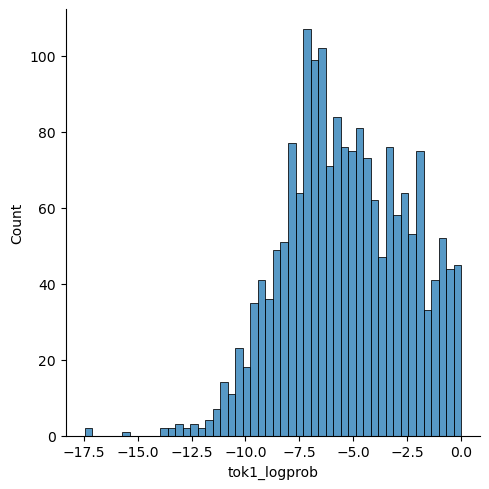

In [13]:
sns.displot(item_df.tok1_logprob, bins=50)

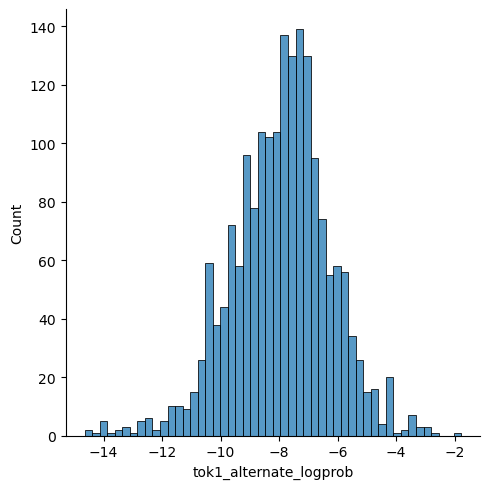

In [14]:
sns.displot(item_df.tok1_alternate_logprob, bins=50)

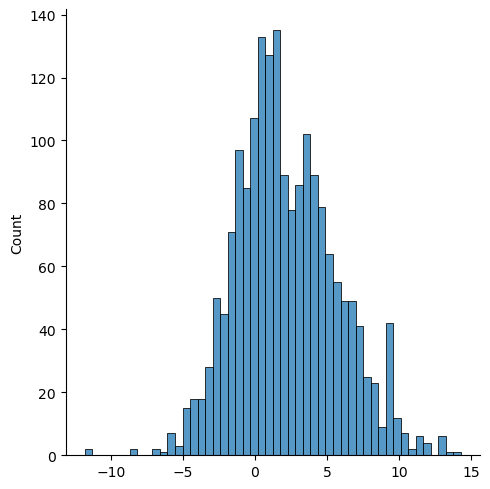

In [15]:
sns.displot(item_df.tok1_logprob - item_df.tok1_any_logprob, bins=50)

In [16]:
item_df.to_csv("intermediates/AISHELL/item_df.2.csv", index=False)

In [17]:
def replace_hanzi(row):
    toks = row.hanzi.split(" ")
    toks[row.start_token_idx] = row.tok1_alternate_hanzi
    return " ".join(toks)

candidate_df = item_df.loc[(item_df.tok1_logprob - item_df.tok1_any_logprob).abs() < 0.5, ["hanzi", "pinyin", "start_token_idx", "tok1", "tok1_hanzi", "tok1_alternate_hanzi", "tok1_alternate_logprob", "tok1_logprob", "tok1_any_logprob"]]
candidate_df["hanzi_alternate"] = candidate_df.apply(replace_hanzi, axis=1)
candidate_df.sample(n=20)[["hanzi", "hanzi_alternate", "pinyin", "tok1_hanzi", "tok1_alternate_hanzi", "tok1_logprob", "tok1_alternate_logprob", "tok1_any_logprob"]]

# good according to Yizhen
# 	hanzi	hanzi_alternate	pinyin	tok1_hanzi	tok1_alternate_hanzi	tok1_logprob	tok1_alternate_logprob	tok1_any_logprob
# 896	每 两 发 就 要 淘 汰 一 人	没 两 发 就 要 淘 汰 一 人	mei2 liang3 fa1 jiu4 yao4 tao2 tai4 yi4 ren2	每	没	-7.061035	-8.092500	-7.057125
# 1526	此 举 只 是 高 端 智 能 的 开 端	此 局 只 是 高 端 智 能 的 开 端	ci2 ju2 zi3 shi4 gao1 duan1 zhi4 neng2 de5 kai...	举	局	-7.725970	-8.229983	-8.188135
# 1242	兴 庆 区 月 牙 湖 乡 人 民 调 解 委 员 会	兴 庆 区 月 牙 湖 乡 人 民 调 节 委 员 会	xing1 qing4 qu1 yue4 ya2 hu2 xiang1 ren2 min2 ...	解	节	-4.460863	-4.707345	-4.649586

,hanzi,hanzi_alternate,pinyin,tok1_hanzi,tok1_alternate_hanzi,tok1_logprob,tok1_alternate_logprob,tok1_any_logprob
1141,其 显 然 不 愿 错 过 高 端 移 动 显 示 屏 这 个 市 场 大 蛋 糕,起 显 然 不 愿 错 过 高 端 移 动 显 示 屏 这 个 市 场 大 蛋 糕,qi2 xian3 ran2 bu2 yuan4 cuo4 guo4 gao1 duan1 ...,其,起,-6.512658,-7.016763,-6.580397
566,需 要 政 府 与 企 业 共 同 投 资 合 作,需 要 政 府 于 企 业 共 同 投 资 合 作,xu1 yao4 zheng4 fu3 yu2 qi3 ye4 gong4 tong2 to...,与,于,-6.967045,-7.728092,-7.104779
1793,其 姐 姐 怂 恿 丈 夫 帮 忙,起 姐 姐 怂 恿 丈 夫 帮 忙,qi2 jie3 jie1 song2 yong3 zang4 fu5 bang1 mang2,其,起,-6.512656,-7.016763,-6.580397
1089,白 电 全 行 业 渐 入 深 冬,百 电 全 行 业 渐 入 深 冬,bai2 dian3 quan2 hang2 ye4 jian4 ru4 shen1 dong1,白,百,-7.503004,-7.651623,-7.322311
1353,相 信 这 场 绞 杀 大 战 必 定 异 常 惨 烈,相 信 这 常 绞 杀 大 战 必 定 异 常 惨 烈,xiang1 xin4 zhe4 chang2 jiao3 sha1 da4 zhan4 b...,场,常,-7.947318,-8.672603,-8.032775
1474,唱 完 美 主 义,唱 完 没 主 义,chang4 wan2 mei2 zhu3 yi4,美,没,-7.411996,-7.599149,-7.283081
466,计 提 比 例 为 百 分 之 一,计 体 比 例 为 百 分 之 一,ji4 ti2 bi3 li4 wei2 bai3 fen1 zhi1 yi1,提,体,-7.259893,-7.738523,-7.738523
1726,巴 黎 麦 当 劳 也 卖 啤 酒,巴 黎 麦 当 老 也 卖 啤 酒,ba1 li2 mai4 dang1 lao2 ye3 mai4 pi2 jiu3,劳,老,-6.794770,-6.842080,-6.720956
1133,一 住 户 家 办 喜 酒 燃 放 花 炮 惊 扰 附 近 马 蜂 窝,一 住 户 家 办 媳 酒 燃 放 花 炮 惊 扰 附 近 马 蜂 窝,yi2 zhu4 hu4 jia1 ban4 xi2 jiu3 ran2 fang4 hua...,喜,媳,-7.791600,-8.156243,-7.519856
1802,中 央 对 其 重 视 远 超 市 场 想 象,中 央 对 其 重 视 远 超 市 长 想 象,zhong1 yang1 dui4 qi2 zhong4 shi4 yuan3 chao1 ...,场,长,-5.166141,-5.238595,-4.968119


In [18]:
item_df[item_df.tok1_hanzi == "举"]

,case,Unnamed: 1,file,hanzi,pinyin,pinyin_underlying,tok1,tok2,start_token_idx,end_token_idx,...,preceding_syllable_forms_word,slice_start,slice_end,slice_file,tok1_hanzi,tok1_alternate,tok1_alternate_hanzi,tok1_alternate_logprob,tok1_logprob,tok1_any_logprob
852,6,0,SSB03390416,或 许 我 们 可 以 一 举 打 掉 整 个 犯 罪 组 织,huo4 xu2 wo3 men5 ke2 yi3 yi4 ju2 da3 diao4 zh...,huo4 xu6 wo3 men5 ke6 yi3 yi4 ju6 da3 diao4 zh...,ju6,da3,7,9,...,True,340,2490,intermediates/AISHELL/render/SSB03390416_juda3...,举,ju2,局,-9.658413,-5.802710,-9.595918
853,6,1,SSB19390456,并 一 举 打 破 亚 洲 纪 录 二 零 一 四 年 九 月,bing4 yi4 ju2 da3 po4 ya4 zhou1 ji4 lu4 er4 li...,bing4 yi4 ju6 da3 po4 ya4 zhou1 ji4 lu4 er4 li...,ju6,da3,2,4,...,True,0,2360,intermediates/AISHELL/render/SSB19390456_juda3...,举,ju2,局,-9.154115,-4.642258,-9.083323
1526,6,0,SSB03850185,此 举 只 是 高 端 智 能 的 开 端,ci2 ju2 zi3 shi4 gao1 duan1 zhi4 neng2 de5 kai...,ci6 ju6 zi3 shi4 gao1 duan1 zhi4 neng2 de5 kai...,ju6,zi3,1,3,...,False,0,2670,intermediates/AISHELL/render/SSB03850185_juzi3...,举,ju2,局,-8.229983,-7.725970,-8.188135
1744,6,0,SSB07230353,本 次 的 选 举 也 完 全 符 合 了 这 个 要 求,ben3 ci4 de5 xuan2 ju2 ye3 wan2 quan2 fu2 he2 ...,ben3 ci4 de5 xuan6 ju6 ye3 wan2 quan2 fu2 he2 ...,ju6,ye3,4,6,...,True,129,2550,intermediates/AISHELL/render/SSB07230353_juye3...,举,ju2,局,-7.792572,-3.263348,-7.708250


In [19]:
candidate_df.loc[1526]

hanzi                                                 此 举 只 是 高 端 智 能 的 开 端
pinyin                    ci2 ju2 zi3 shi4 gao1 duan1 zhi4 neng2 de5 kai...
start_token_idx                                                           1
tok1                                                                    ju6
tok1_hanzi                                                                举
tok1_alternate_hanzi                                                      局
tok1_alternate_logprob                                            -8.229983
tok1_logprob                                                       -7.72597
tok1_any_logprob                                                  -8.188135
hanzi_alternate                                       此 局 只 是 高 端 智 能 的 开 端
Name: 1526, dtype: object

## Compute `CouldBeLexical`

In [29]:
# Index all possible pinyin bigrams
pinyin_bigrams = defaultdict(set)
for word, readings in cedict.items():
    for reading in readings:
        if reading.count(" ") == 1:
            pinyin_bigrams[reading].add(word)

In [41]:
def compute_couldbelexical(row):
    hanzi_tokens = row.hanzi.split(" ")
    a, b, c = hanzi_tokens[row.start_token_idx - 1], hanzi_tokens[row.start_token_idx], hanzi_tokens[row.start_token_idx + 1]
    pinyin_tokens = row.pinyin.split(" ")
    a_pinyin, b_pinyin, c_pinyin = pinyin_tokens[row.start_token_idx - 1], pinyin_tokens[row.start_token_idx], pinyin_tokens[row.start_token_idx + 1]

    couldbelexical_ab = f"{a_pinyin} {b_pinyin}" in pinyin_bigrams
    couldbelexical_bc = f"{b_pinyin} {c_pinyin}" in pinyin_bigrams

    return couldbelexical_ab, couldbelexical_bc

In [42]:
candidate_df["couldbelexical_ab"], candidate_df["couldbelexical_bc"] = zip(*candidate_df.apply(compute_couldbelexical, axis=1))
candidate_df

,hanzi,pinyin,start_token_idx,tok1,tok1_hanzi,tok1_alternate_hanzi,tok1_alternate_logprob,tok1_logprob,tok1_any_logprob,hanzi_alternate,couldbelexical_ab,couldbelexical_bc
1,国 有 独 资 类 医 院 有 什 么,guo2 you3 du2 zi1 lei4 yi1 yuan4 you3 shen2 me5,0,guo2,国,果,-6.939235,-6.803962,-6.905598,果 有 独 资 类 医 院 有 什 么,False,True
4,连 续 有 国 有 和 民 营 资 本 投 资 设 立 保 险 公 司,lian2 xu4 you3 guo2 you3 he2 min2 ying2 zi1 be...,3,guo2,国,果,-7.912278,-7.785870,-7.906475,连 续 有 果 有 和 民 营 资 本 投 资 设 立 保 险 公 司,False,True
26,教 育 术 语 有 什 么,jiao4 yu4 shu4 yu2 you3 shen2 me5,3,yu6,语,与,-5.370756,-5.398130,-5.042150,教 育 术 与 有 什 么,False,False
29,澳 门 的 岛 屿 有 什 么,ao4 men2 de5 dao2 yu2 you3 shen2 me5,4,yu6,屿,与,-2.935004,-3.053084,-2.904689,澳 门 的 岛 与 有 什 么,False,False
37,你 使 我 的 任 务 更 麻 烦 了,ni2 shi2 wo3 de5 ren4 wu4 geng4 ma2 fan4 le5,1,shi6,使,什,-8.337626,-7.158304,-7.091424,你 什 我 的 任 务 更 麻 烦 了,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1839,媒 体 曝 高 桥 留 美 表 面 上 是 为 了 进 修 外 语,mou2 ti3 bao4 gao1 qiao2 liu2 mei3 biao3 mian4...,0,mou2,媒,某,-8.636718,-8.449336,-8.636718,某 体 曝 高 桥 留 美 表 面 上 是 为 了 进 修 外 语,False,False
1841,法 院 就 此 发 出 了 风 险 提 示,fa3 yuan4 jiu4 ci3 fa1 chu1 le5 feng1 xie2 ti3...,8,xie2,险,写,-9.823958,-9.434031,-9.823958,法 院 就 此 发 出 了 风 写 提 示,True,True
1842,爱 因 斯 坦 手 写 体 亮 相 南 京 表 达 反 战 呼 声,ai4 yin1 si1 tan3 shou2 xie2 ti3 liang4 xiang4...,5,xie6,写,携,-6.820979,-6.283875,-6.301037,爱 因 斯 坦 手 携 体 亮 相 南 京 表 达 反 战 呼 声,False,True
1846,还 是 等 市 场 给 出 答 案 吧,hai2 shi4 deng3 shi4 chang2 gei3 chu1 da2 an4 ba5,4,chang6,场,长,-6.138256,-5.554757,-6.036999,还 是 等 市 长 给 出 答 案 吧,False,False


In [44]:
candidate_df.couldbelexical_ab.value_counts()

couldbelexical_ab
False    147
True      64
Name: count, dtype: int64

In [45]:
candidate_df.couldbelexical_bc.value_counts()

couldbelexical_bc
False    155
True      56
Name: count, dtype: int64

In [46]:
(candidate_df.couldbelexical_ab & candidate_df.couldbelexical_bc).value_counts()

False    194
True      17
Name: count, dtype: int64